# Select velocity along circumpolar 1 km isobath

This script:

1. Calculates along-slope and cross-slope velocity.
2. Selects the velocities on the 1 km isobath (on u grid). The isobath information is calculated in `Find_depth_contour_plt_approach.ipynb` and is loaded in here.
3. Saves a 10 year climatology (or daily data) of the along-slope and cross-slope velocity to a post-processed file. It takes a long time to load in the data, this should help when playing around when plotting the data later. Select ncpus=48 to run the script when calculating the climatology or otherwise you run out of memory.

Load modules:

In [1]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
#from cosima_cookbook import distributed as ccd
# Optional modules
#import xarray.ufuncs as xu
import xgcm
from joblib import Parallel, delayed

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores:

In [2]:
client = Client(n_workers=8) # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 32,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35449,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:42091,Total threads: 4
Dashboard: /proxy/36679/status,Memory: 31.40 GiB
Nanny: tcp://127.0.0.1:42213,


Nominate a database from which to load the data and define an experiment:

In [5]:
# Load database
#session = cc.database.create_session('/g/data/ik11/databases/ryf9091.db')
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

### Topographic gradient

In [4]:
lat_slice = slice(-80, -59)

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)

# Import grid cell length
dxu = cc.querying.getvar(expt, 'dxu', session, n=1)
dyu = cc.querying.getvar(expt, 'dyu', session, n=1)

# Change coordinate name
dxu.coords['ni'] = hu['xu_ocean'].values
dxu.coords['nj'] = hu['yu_ocean'].values
dyu.coords['ni'] = hu['xu_ocean'].values
dyu.coords['nj'] = hu['yu_ocean'].values
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))

# Select latitude range
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()
dxu = dxu.sel(yu_ocean=lat_slice)
dxu = dxu.load()
dyu = dyu.sel(yu_ocean=lat_slice)
dyu = dyu.load()

Calculate grad h using xgcm functions (following method 3 in `RelativeVorticity.ipynb` from [cosima recipes](https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/RelativeVorticity.ipynb))

In [6]:
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [7]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')

# Same as: (other option)
#dhu_dx = grid.interp(grid.diff(ds.hu, 'X'), 'X') / ds.dxu
#dhu_dy = grid.interp(grid.diff(ds.hu, 'Y', boundary='extend'), 'Y', boundary='extend') / ds.dyu

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

In [8]:
# Calculate the magnitude of the topographic slope
slope = np.sqrt(dhu_dx**2 + dhu_dy**2)

### Along-slope and cross-slope velocity  

In [9]:
# Load velocity data

# Time slice used in Huneke et al. 2022
start_time = '2080-01-01'
end_time   = '2089-12-31' 

# Time slice matching DSW export in Easterlies run
start_time = '2150-01-01'
end_time   = '2159-12-31'

u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)#.mean('time')
v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
v = v.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)#.mean('time')

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23067968456512 and this is thread id 23064690132736.
Exception closing connection <sqlite3.Connection object at 0x14fa2b106d50>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-pa

Rotate velocity

In [10]:
# Along-slope velocity
u_along = u*dhu_dy/slope - v*dhu_dx/slope
# Cross-slope velocity
v_cross = u*dhu_dx/slope + v*dhu_dy/slope

Monthly climatology

In [11]:
u_along = u_along.groupby('time.month').mean('time')
v_cross = v_cross.groupby('time.month').mean('time')

Barotropic velocity

In [12]:
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':u.yu_ocean,'xu_ocean':u.xu_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
thickness = thickness

In [13]:
# Barotropic velocity
u_btr = (u_along * thickness).sum('st_ocean') / thickness.sum('st_ocean')
v_btr = (v_cross * thickness).sum('st_ocean') / thickness.sum('st_ocean')

Load data

In [ ]:
# Load the data (this is necessary for selecting the points along the contour, otherwise the code will run forever)
u_along = u_along.load()

In [ ]:
u_btr   = u_btr.load()

In [ ]:
# v_cross = v_cross.load()
# v_btr   = v_btr.load()

### Load the isobath information

These are previously calculated (`Find_depth_contour_plt_approach.ipynb`)

In [15]:
isobath_depth = 1000

In [16]:
# Load the isobath information
file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_u_t_' + str(isobath_depth) + 'm_plt_approach.npz'
data = np.load(file_path)

In [17]:
# We are interested in the u-grid:
num_points = data['num_points_u']
distance_along_contour = data['distance_along_contour_u']
lon_along_contour = data['lon_along_contour_u']
lat_along_contour = data['lat_along_contour_u']

### Velocities along contour

In [18]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [37]:
save_dir  = '/g/data/x77/wgh581/Post_Process/'
file_name = 'Antarctic_slope_contour_1km_velocities_plt_approach_2150_2159.nc'

In [19]:
# Julia's method to select values along contour (parallelised)

In [22]:
def get_data_u_along_contour(data, ii):
    return data.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest').values

In [52]:
results = Parallel(n_jobs=-1)(delayed(get_data_u_along_contour)(u_along, ii) for ii in range(num_points))

u_along_contour = np.zeros((len(month), len(u_along.st_ocean), num_points))
for ii in range(num_points):
    u_along_contour[:,:,ii] = results[ii]

u_along_darray = xr.DataArray(u_along_contour[:,:,:-1], name='u_along', dims=['month','st_ocean','distance_along_contour'],
                           coords={'month':month, 'st_ocean':u_along['st_ocean'], 'distance_along_contour':distance_along_contour[:-1]})

In [38]:
# u_along_darray.to_netcdf(save_dir+file_name)

Barotropic velocity

In [53]:
results = Parallel(n_jobs=-1)(delayed(get_data_u_along_contour)(u_btr, ii) for ii in range(num_points))

u_btr_contour = np.zeros((len(month), num_points))
for ii in range(num_points):
    u_btr_contour[:,ii] = results[ii]
    
u_btr_darray = xr.DataArray(u_btr_contour[:,:-1], name='u_btr', dims=['month','distance_along_contour'],
                           coords={'month':month, 'distance_along_contour':distance_along_contour[:-1]})

In [55]:
u_ds = u_along_darray.to_dataset()
u_ds['u_btr'] = u_btr_darray

u_ds.to_netcdf(save_dir+file_name)

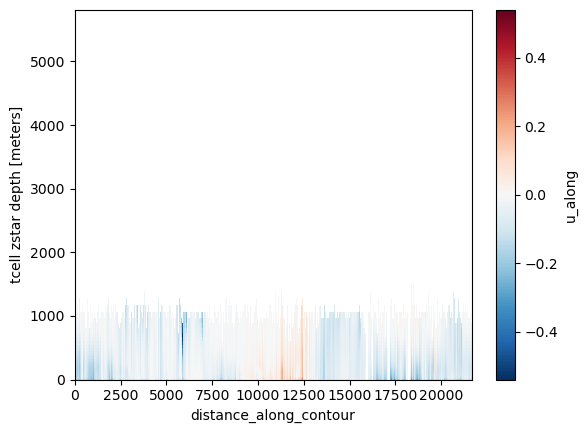

In [56]:
u_ds.u_along.mean('month').plot()

---

In [ ]:
# PREVIOUS METHOD

Along-slope component

In [20]:
# Total velocity along contour
u_along_contour = np.zeros((len(month), len(u_along.st_ocean), num_points))
for ii in range(num_points):
    u_along_contour[:,:,ii] = u_along.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest')

In [21]:
# Barotropic velocity along contour
u_btr_contour = np.zeros((len(month),num_points))
for ii in range(num_points):
    u_btr_contour[:,ii] = u_btr.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest')

Cross-slope component

In [22]:
# Total velocity along contour
v_cross_contour = np.zeros((len(month), len(v_cross.st_ocean), num_points))
for ii in range(num_points):
    v_cross_contour[:,:,ii] = v_cross.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest')

In [23]:
# Barotropic velocity along contour
v_btr_contour = np.zeros((len(month),num_points))
for ii in range(num_points):
    v_btr_contour[:,ii] = v_btr.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest')

Grid cell thickness

In [24]:
thickness_contour = np.zeros((len(thickness.st_ocean), num_points))
for ii in range(num_points):
    thickness_contour[:,ii] = thickness.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest')

### Saving

Save the data as *.npz data construct.

In [28]:
import os
save_dir  = '/g/data/x77/wgh581/Post_Process/'
file_name = 'Antarctic_slope_contour_1km_velocities_plt_approach'
outfile   = os.path.join(save_dir, file_name+'.npz')

np.savez(outfile, u_along_contour=u_along_contour, v_cross_contour=v_cross_contour, \
         u_btr_contour=u_btr_contour, v_btr_contour=v_btr_contour, \
         lat_along_contour=lat_along_contour, lon_along_contour=lon_along_contour, \
         num_points=num_points, distance_along_contour=distance_along_contour, \
         st_ocean=u_along.st_ocean, thickness_contour=thickness_contour)


---
Test if saving the data worked:

In [18]:
testfile = save_dir+file_name+'.npz'
data = np.load(testfile)
data.files

['u_along_contour',
 'v_cross_contour',
 'u_btr_contour',
 'v_btr_contour',
 'lat_along_contour',
 'lon_along_contour',
 'num_points',
 'distance_along_contour',
 'st_ocean',
 'thickness_contour']

In [40]:
test = data['u_btr_contour']
np.shape(test)

(12, 5936)

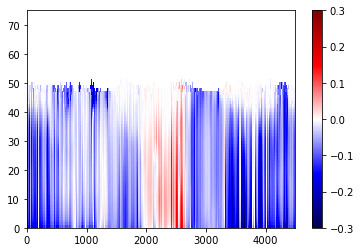

In [33]:
fig = plt.figure()
plt.pcolormesh(u_along_contour.mean(axis=0), cmap='seismic', vmin=-0.3, vmax=0.3)
plt.colorbar();

In [34]:
np.shape(u_along_contour)

(12, 75, 4487)

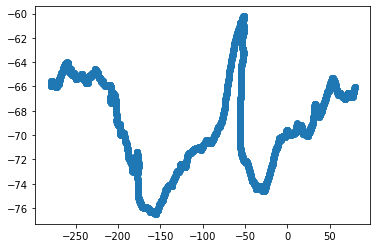

In [27]:
fig = plt.figure()
plt.scatter(lon_along_contour, lat_along_contour)